<a href="https://colab.research.google.com/github/joyjoy120808/Distinguishing-gravitational-waves-amid-artificial-noise./blob/main/%E6%9C%80%E7%B5%82%E6%96%B9%E6%A1%88_whitenoise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install -q pycbc

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 24.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 5.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Wavedata

Mounted at /content/drive
/content/drive/MyDrive/Wavedata


In [5]:
import os
from pathlib import Path
from tqdm import tqdm
import h5py
import json

import numpy as np
from pycbc.waveform import get_td_waveform
import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch import Tensor
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

%matplotlib inline

/usr/local/lib/python3.10/dist-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


In [6]:
TRAIN_TOTAL, VALID_TOTAL, TEST_TOTAL = 10000, 1000, 1000
IFOS, KERNEL = 1, 8192

DATA_BASE = '/content/drive/MyDrive/Wavedata/Data'
OUT_BASE = '/content/drive/MyDrive/Wavedata/Outputs'

TRAINING_FILE = f'{DATA_BASE}/training_data.h5'
VALIDATION_FILE = f'{DATA_BASE}/validation_data.h5'
TESTING_FILE = f'{DATA_BASE}/testing_data.h5'

In [7]:
!mkdir -p /content/drive/MyDrive/Wavedata/Data
!mkdir -p /content/drive/MyDrive/Wavedata/Outputs

100%|██████████| 5000/5000 [27:28<00:00,  3.03it/s]


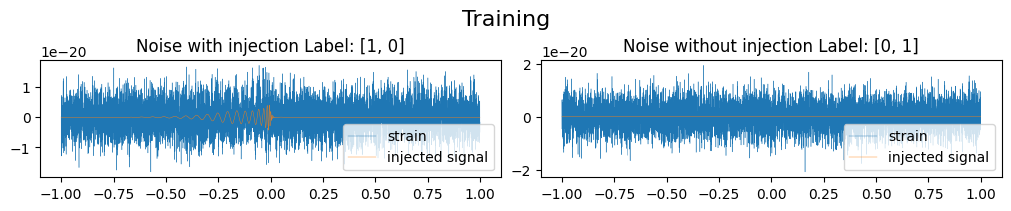

100%|██████████| 500/500 [02:48<00:00,  2.96it/s]


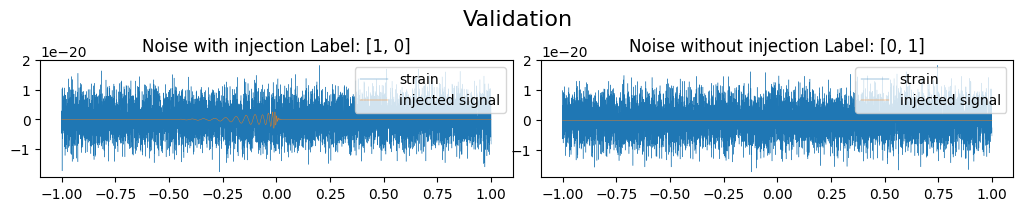

100%|██████████| 500/500 [02:47<00:00,  2.99it/s]


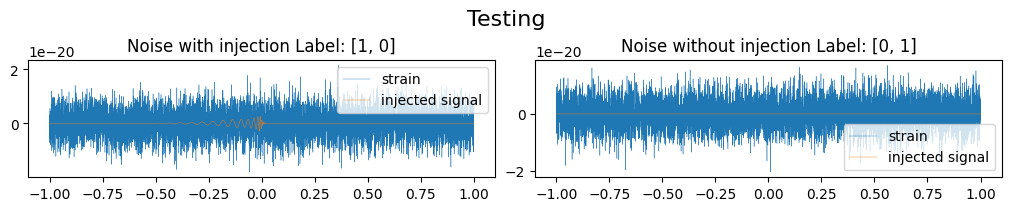

In [8]:
data_set_name = ['Training', 'Validation', 'Testing']
data_files = [TRAINING_FILE, VALIDATION_FILE, TESTING_FILE]
time = np.arange(-1, 1, 1/4096)
strains = []
targets = []

for idx, data_size in enumerate([TRAIN_TOTAL, VALID_TOTAL, TEST_TOTAL]):
    if Path(data_files[idx]).exists() == False:

        signals = np.zeros([int(data_size), KERNEL])
        inputs = 1e-20*0.5*np.random.normal(0, 1, (data_size, 8192))

        parameters = {'mass1':[], 'mass2':[], 'distance':[]}
        for j in tqdm(range(int(data_size/2))):
            m1, m2, distance = np.random.uniform(30, 80, 1), np.random.uniform(30, 80, 1), np.random.uniform(300, 1000, 1)
            mass1, mass2 = max(m1, m2), min(m1, m2)
            parameters['mass1'].append(mass1[0])
            parameters['mass2'].append(mass2[0])
            parameters['distance'].append(distance[0])

            hp, hc = get_td_waveform(
                approximant='IMRPhenomPv2',
                mass1=mass1[0],
                mass2=mass2[0],
                spin1x=0,
                spin1y=0,
                spin1z=0,
                spin2x=0,
                spin2y=0,
                spin2z=0,
                distance=distance,
                inclination=0,
                coa_phase=0,
                f_lower=20,
                f_ref=20,
                delta_t=1/4096
            )
            hp_crop = hp.crop(-1 - hp.start_time, hp.end_time - 1)
            hp_array = np.array(hp_crop)

            signals[j, :] += hp_array

        inputs += signals

        target = np.r_[
            np.repeat(np.array([[1,0]]), int(data_size/2), axis=0),
            np.repeat(np.array([[0,1]]), int(data_size/2), axis=0)
        ]

        strains.append(inputs)
        targets.append(target)

        #Saving the data
        with h5py.File(data_files[idx], 'w') as g1:
            g1.create_dataset('Input', data=inputs)
            g1.create_dataset('Target', data=target)

        with open(f'{DATA_BASE}/{data_set_name[idx]}-parameters.json', 'w') as fp:
            json.dump(parameters, fp)

        #Plots the data
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10, 2), constrained_layout=True)
        fig.suptitle(f'{data_set_name[idx]}', fontsize=16)
        ax[0].set_title('Noise with injection Label: [1, 0]')
        ax[0].plot(time, inputs[0], lw=0.3, label='strain')
        ax[0].plot(time, signals[0], lw=0.3, label='injected signal')
        ax[0].legend()

        ax[1].set_title('Noise without injection Label: [0, 1]')
        ax[1].plot(time, inputs[-1], lw=0.3, label='strain')
        ax[1].plot(time, signals[-1], lw=0.3, label='injected signal')
        ax[1].legend()

        plt.show()
        plt.close()


    else:
        with h5py.File(data_files[idx], 'r') as h1:

            print(f'Start Loading {data_set_name[idx]} data...')
            strains.append(h1['Input'][:])
            targets.append(h1['Target'][:])
            print(f'{data_set_name[idx]} data Loaded!')

# DataLoader

In [9]:
class MyDataset(Dataset):

    def __init__(self, data, target, ifos=1, kernel_size=8192):

        self.data = torch.FloatTensor(
            1e21*data.reshape([-1, ifos, kernel_size])
        )

        self.targets = torch.LongTensor(target)

    def __len__(self):

        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        return x, y

In [10]:
# Load Training data into pytorch tensor
dataset = MyDataset(strains[0], targets[0])

training_data = DataLoader(
    dataset,
    batch_size=64,
    shuffle=True
)

# Load Validation data into pytorch tensor
dataset_v = MyDataset(strains[1], targets[1])
validation_data = DataLoader(
    dataset_v,
    batch_size=32,
    shuffle=True
)

# Warmup

In [11]:
# Input Tensors

BATCH_SIZE, CHANNELS, SHAPE = 128, 2, 4096
input = torch.randn(BATCH_SIZE, CHANNELS, SHAPE)
print(input.shape)

torch.Size([128, 2, 4096])


In [12]:

# Linear
linear = nn.Linear(
    in_features=SHAPE,
    out_features=20)

# Conv
conv = nn.Conv1d(
    in_channels=CHANNELS,
    out_channels=20,
    kernel_size=8,
    stride=2
)

# AdaptiveAvgPool1d

pooling = nn.AdaptiveAvgPool1d(output_size=5)

# Get some outputs
linear_output = linear(input)
conv_output = conv(input)
pooling_output = pooling(input)

print(linear_output.shape)
print(conv_output.shape)
print(pooling_output.shape)

torch.Size([128, 2, 20])
torch.Size([128, 20, 2045])
torch.Size([128, 2, 5])


# Build a Model

In [43]:
class MyModel(nn.Module):

    def __init__(self,num_ifos: int,):

        super(MyModel, self).__init__()

        self.conv1 = nn.Conv1d(
            in_channels=num_ifos,
            out_channels=10,
            kernel_size=5,
            stride=2,
            padding=2)

        self.norm1 = nn.BatchNorm1d(num_ifos)
        self.norm2 = nn.BatchNorm1d(10)
        self.conv2 = nn.Conv1d(10, 20, kernel_size=7, stride=2, padding=2)
        self.norm3 = nn.BatchNorm1d(20)
        self.conv3 = nn.Conv1d(20, 10, kernel_size=5, stride=2, padding=2)
        self.norm4 = nn.BatchNorm1d(10)
        self.conv4 = nn.Conv1d(10, 5, kernel_size=5, stride=2, padding=2)
        self.conv1_drop = nn.Dropout1d()
        self.fc1 = nn.Linear(160, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.norm1(x)
        x = F.mish(F.max_pool1d(self.conv1_drop(self.conv1(x)), 2))
        x = self.norm2(x)
        x = F.mish(F.max_pool1d(self.conv1_drop(self.conv2(x)), 2))
        x = self.norm3(x)
        x = F.mish(F.max_pool1d(self.conv1_drop(self.conv3(x)), 2))
        x = self.norm4(x)
        x = F.mish(F.max_pool1d(self.conv1_drop(self.conv4(x)), 2))
        x = torch.flatten(x, 1)
        x = F.mish(self.fc1(x))
        x = F.mish(self.fc2(x))
        x = F.softmax(self.fc3(x), dim = 1)

        return x

In [44]:
Kate_Moss = MyModel(num_ifos=IFOS)
summary(Kate_Moss, (IFOS, KERNEL), 128, 'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm1d-1             [128, 1, 8192]               2
            Conv1d-2            [128, 10, 4096]              60
         Dropout1d-3            [128, 10, 4096]               0
       BatchNorm1d-4            [128, 10, 2048]              20
            Conv1d-5            [128, 20, 1023]           1,420
         Dropout1d-6            [128, 20, 1023]               0
       BatchNorm1d-7             [128, 20, 511]              40
            Conv1d-8             [128, 10, 256]           1,010
         Dropout1d-9             [128, 10, 256]               0
      BatchNorm1d-10             [128, 10, 128]              20
           Conv1d-11               [128, 5, 64]             255
        Dropout1d-12               [128, 5, 64]               0
           Linear-13                  [128, 64]          10,304
           Linear-14                  [

# Training

In [46]:
device = torch.device("cuda")
model = MyModel(num_ifos=IFOS).to(device)
epochs = 100
learning_rate = 0.0005
criterion = nn.CrossEntropyLoss()

opt = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=1e-4
)

cost_value = np.empty(epochs)
cost_valid_value = np.empty(epochs)

for i in range(epochs):
    t_cost = 0
    for j, (x, y) in enumerate(tqdm(training_data, desc=f'Epoch {i+1}')):
        x = x.to(device)
        y = y.to(device)

        p_value = model(x)
        cost = criterion(p_value, torch.argmax(y, dim = 1))

        opt.zero_grad()
        cost.backward()
        opt.step()

        t_cost += cost.item()

    cost_value[i] = t_cost/(j+1)

    print('========')
    print(f'Cost{round(cost_value[i], 2)}')
    print('========', '\n')

    with torch.no_grad():
        v_cost = 0
        for run, (a, b) in enumerate(validation_data):
            a = a.to(device)
            b = b.to(device)

            p_value = model(a)
            cost_valid = criterion(p_value, torch.argmax(b, dim = 1))

            v_cost += cost_valid.item()

        cost_valid_value[i] = v_cost/(run+1)

        print('===================')
        print(f'Validation Cost{round(cost_valid_value[i], 2)}')
        print('===================', '\n')

Epoch 1: 100%|██████████| 157/157 [00:01<00:00, 129.23it/s]


Cost0.69

Validation Cost0.69



Epoch 2: 100%|██████████| 157/157 [00:01<00:00, 146.97it/s]


Cost0.69

Validation Cost0.69



Epoch 3: 100%|██████████| 157/157 [00:01<00:00, 127.39it/s]


Cost0.69

Validation Cost0.69



Epoch 4: 100%|██████████| 157/157 [00:01<00:00, 117.53it/s]


Cost0.69

Validation Cost0.69



Epoch 5: 100%|██████████| 157/157 [00:01<00:00, 98.75it/s]


Cost0.69

Validation Cost0.69



Epoch 6: 100%|██████████| 157/157 [00:01<00:00, 126.07it/s]


Cost0.69

Validation Cost0.69



Epoch 7: 100%|██████████| 157/157 [00:01<00:00, 125.78it/s]


Cost0.69

Validation Cost0.69



Epoch 8: 100%|██████████| 157/157 [00:01<00:00, 127.84it/s]


Cost0.65

Validation Cost0.61



Epoch 9: 100%|██████████| 157/157 [00:01<00:00, 127.85it/s]


Cost0.59

Validation Cost0.59



Epoch 10: 100%|██████████| 157/157 [00:01<00:00, 125.37it/s]


Cost0.57

Validation Cost0.56



Epoch 11: 100%|██████████| 157/157 [00:01<00:00, 125.18it/s]


Cost0.55

Validation Cost0.54



Epoch 12: 100%|██████████| 157/157 [00:01<00:00, 125.71it/s]


Cost0.54

Validation Cost0.54



Epoch 13: 100%|██████████| 157/157 [00:01<00:00, 112.27it/s]


Cost0.54

Validation Cost0.53



Epoch 14: 100%|██████████| 157/157 [00:01<00:00, 105.41it/s]


Cost0.53

Validation Cost0.53



Epoch 15: 100%|██████████| 157/157 [00:01<00:00, 99.59it/s] 


Cost0.53

Validation Cost0.53



Epoch 16: 100%|██████████| 157/157 [00:01<00:00, 129.35it/s]


Cost0.53

Validation Cost0.53



Epoch 17: 100%|██████████| 157/157 [00:01<00:00, 143.91it/s]


Cost0.52

Validation Cost0.52



Epoch 18: 100%|██████████| 157/157 [00:01<00:00, 125.93it/s]


Cost0.53

Validation Cost0.53



Epoch 19: 100%|██████████| 157/157 [00:01<00:00, 125.92it/s]


Cost0.52

Validation Cost0.52



Epoch 20: 100%|██████████| 157/157 [00:01<00:00, 127.29it/s]


Cost0.52

Validation Cost0.53



Epoch 21: 100%|██████████| 157/157 [00:01<00:00, 127.34it/s]


Cost0.52

Validation Cost0.52



Epoch 22: 100%|██████████| 157/157 [00:01<00:00, 129.37it/s]


Cost0.52

Validation Cost0.52



Epoch 23: 100%|██████████| 157/157 [00:01<00:00, 109.62it/s]


Cost0.52

Validation Cost0.53



Epoch 24: 100%|██████████| 157/157 [00:01<00:00, 98.22it/s]


Cost0.52

Validation Cost0.52



Epoch 25: 100%|██████████| 157/157 [00:01<00:00, 95.85it/s] 


Cost0.51

Validation Cost0.51



Epoch 26: 100%|██████████| 157/157 [00:01<00:00, 126.86it/s]


Cost0.52

Validation Cost0.52



Epoch 27: 100%|██████████| 157/157 [00:01<00:00, 127.24it/s]


Cost0.51

Validation Cost0.53



Epoch 28: 100%|██████████| 157/157 [00:01<00:00, 127.66it/s]


Cost0.51

Validation Cost0.53



Epoch 29: 100%|██████████| 157/157 [00:01<00:00, 127.96it/s]


Cost0.51

Validation Cost0.51



Epoch 30: 100%|██████████| 157/157 [00:01<00:00, 125.21it/s]


Cost0.51

Validation Cost0.52



Epoch 31: 100%|██████████| 157/157 [00:01<00:00, 128.59it/s]


Cost0.51

Validation Cost0.51



Epoch 32: 100%|██████████| 157/157 [00:01<00:00, 127.98it/s]


Cost0.51

Validation Cost0.52



Epoch 33: 100%|██████████| 157/157 [00:01<00:00, 109.52it/s]


Cost0.51

Validation Cost0.52



Epoch 34: 100%|██████████| 157/157 [00:01<00:00, 104.84it/s]


Cost0.51

Validation Cost0.52



Epoch 35: 100%|██████████| 157/157 [00:01<00:00, 103.12it/s]


Cost0.51

Validation Cost0.51



Epoch 36: 100%|██████████| 157/157 [00:01<00:00, 127.31it/s]


Cost0.51

Validation Cost0.51



Epoch 37: 100%|██████████| 157/157 [00:01<00:00, 130.35it/s]


Cost0.51

Validation Cost0.53



Epoch 38: 100%|██████████| 157/157 [00:01<00:00, 126.22it/s]


Cost0.51

Validation Cost0.53



Epoch 39: 100%|██████████| 157/157 [00:01<00:00, 127.97it/s]


Cost0.51

Validation Cost0.5



Epoch 40: 100%|██████████| 157/157 [00:01<00:00, 126.92it/s]


Cost0.51

Validation Cost0.52



Epoch 41: 100%|██████████| 157/157 [00:01<00:00, 127.30it/s]


Cost0.51

Validation Cost0.51



Epoch 42: 100%|██████████| 157/157 [00:01<00:00, 127.46it/s]


Cost0.51

Validation Cost0.5



Epoch 43: 100%|██████████| 157/157 [00:01<00:00, 107.76it/s]


Cost0.51

Validation Cost0.5



Epoch 44: 100%|██████████| 157/157 [00:01<00:00, 98.94it/s]


Cost0.51

Validation Cost0.52



Epoch 45: 100%|██████████| 157/157 [00:01<00:00, 99.61it/s] 


Cost0.51

Validation Cost0.5



Epoch 46: 100%|██████████| 157/157 [00:01<00:00, 123.57it/s]


Cost0.51

Validation Cost0.52



Epoch 47: 100%|██████████| 157/157 [00:01<00:00, 124.78it/s]


Cost0.51

Validation Cost0.51



Epoch 48: 100%|██████████| 157/157 [00:01<00:00, 125.93it/s]


Cost0.51

Validation Cost0.5



Epoch 49: 100%|██████████| 157/157 [00:01<00:00, 128.28it/s]


Cost0.51

Validation Cost0.51



Epoch 50: 100%|██████████| 157/157 [00:01<00:00, 128.62it/s]


Cost0.5

Validation Cost0.52



Epoch 51: 100%|██████████| 157/157 [00:01<00:00, 125.19it/s]


Cost0.51

Validation Cost0.51



Epoch 52: 100%|██████████| 157/157 [00:01<00:00, 125.57it/s]


Cost0.51

Validation Cost0.51



Epoch 53: 100%|██████████| 157/157 [00:01<00:00, 108.75it/s]


Cost0.51

Validation Cost0.51



Epoch 54: 100%|██████████| 157/157 [00:01<00:00, 122.72it/s]


Cost0.51

Validation Cost0.5



Epoch 55: 100%|██████████| 157/157 [00:01<00:00, 108.63it/s]


Cost0.5

Validation Cost0.5



Epoch 56: 100%|██████████| 157/157 [00:01<00:00, 145.46it/s]


Cost0.51

Validation Cost0.51



Epoch 57: 100%|██████████| 157/157 [00:01<00:00, 145.65it/s]


Cost0.51

Validation Cost0.51



Epoch 58: 100%|██████████| 157/157 [00:01<00:00, 148.97it/s]


Cost0.51

Validation Cost0.5



Epoch 59: 100%|██████████| 157/157 [00:01<00:00, 148.14it/s]


Cost0.51

Validation Cost0.51



Epoch 60: 100%|██████████| 157/157 [00:01<00:00, 144.99it/s]


Cost0.51

Validation Cost0.51



Epoch 61: 100%|██████████| 157/157 [00:01<00:00, 145.18it/s]


Cost0.51

Validation Cost0.5



Epoch 62: 100%|██████████| 157/157 [00:01<00:00, 147.05it/s]


Cost0.5

Validation Cost0.52



Epoch 63: 100%|██████████| 157/157 [00:01<00:00, 146.92it/s]


Cost0.5

Validation Cost0.51



Epoch 64: 100%|██████████| 157/157 [00:01<00:00, 127.89it/s]


Cost0.5

Validation Cost0.5



Epoch 65: 100%|██████████| 157/157 [00:01<00:00, 119.99it/s]


Cost0.5

Validation Cost0.52



Epoch 66: 100%|██████████| 157/157 [00:01<00:00, 114.23it/s]


Cost0.51

Validation Cost0.51



Epoch 67: 100%|██████████| 157/157 [00:01<00:00, 148.26it/s]


Cost0.5

Validation Cost0.51



Epoch 68: 100%|██████████| 157/157 [00:01<00:00, 144.02it/s]


Cost0.5

Validation Cost0.51



Epoch 69: 100%|██████████| 157/157 [00:01<00:00, 143.48it/s]


Cost0.5

Validation Cost0.5



Epoch 70: 100%|██████████| 157/157 [00:01<00:00, 141.47it/s]


Cost0.5

Validation Cost0.51



Epoch 71: 100%|██████████| 157/157 [00:01<00:00, 145.43it/s]


Cost0.5

Validation Cost0.5



Epoch 72: 100%|██████████| 157/157 [00:01<00:00, 127.76it/s]


Cost0.5

Validation Cost0.5



Epoch 73: 100%|██████████| 157/157 [00:01<00:00, 124.92it/s]


Cost0.5

Validation Cost0.51



Epoch 74: 100%|██████████| 157/157 [00:01<00:00, 126.86it/s]


Cost0.5

Validation Cost0.5



Epoch 75: 100%|██████████| 157/157 [00:01<00:00, 102.81it/s]


Cost0.5

Validation Cost0.5



Epoch 76: 100%|██████████| 157/157 [00:01<00:00, 103.55it/s]


Cost0.51

Validation Cost0.5



Epoch 77: 100%|██████████| 157/157 [00:01<00:00, 111.81it/s]


Cost0.5

Validation Cost0.5



Epoch 78: 100%|██████████| 157/157 [00:01<00:00, 127.61it/s]


Cost0.5

Validation Cost0.5



Epoch 79: 100%|██████████| 157/157 [00:01<00:00, 128.70it/s]


Cost0.5

Validation Cost0.51



Epoch 80: 100%|██████████| 157/157 [00:01<00:00, 123.75it/s]


Cost0.5

Validation Cost0.51



Epoch 81: 100%|██████████| 157/157 [00:01<00:00, 123.77it/s]


Cost0.5

Validation Cost0.51



Epoch 82: 100%|██████████| 157/157 [00:01<00:00, 125.78it/s]


Cost0.5

Validation Cost0.51



Epoch 83: 100%|██████████| 157/157 [00:01<00:00, 127.54it/s]


Cost0.51

Validation Cost0.5



Epoch 84: 100%|██████████| 157/157 [00:01<00:00, 120.09it/s]


Cost0.5

Validation Cost0.51



Epoch 85: 100%|██████████| 157/157 [00:01<00:00, 111.96it/s]


Cost0.5

Validation Cost0.51



Epoch 86: 100%|██████████| 157/157 [00:01<00:00, 115.01it/s]


Cost0.5

Validation Cost0.51



Epoch 87: 100%|██████████| 157/157 [00:01<00:00, 104.11it/s]


Cost0.51

Validation Cost0.5



Epoch 88: 100%|██████████| 157/157 [00:01<00:00, 124.38it/s]


Cost0.5

Validation Cost0.49



Epoch 89: 100%|██████████| 157/157 [00:01<00:00, 124.04it/s]


Cost0.51

Validation Cost0.51



Epoch 90: 100%|██████████| 157/157 [00:01<00:00, 123.43it/s]


Cost0.5

Validation Cost0.51



Epoch 91: 100%|██████████| 157/157 [00:01<00:00, 123.69it/s]


Cost0.5

Validation Cost0.49



Epoch 92: 100%|██████████| 157/157 [00:01<00:00, 124.50it/s]


Cost0.5

Validation Cost0.51



Epoch 93: 100%|██████████| 157/157 [00:01<00:00, 125.32it/s]


Cost0.5

Validation Cost0.5



Epoch 94: 100%|██████████| 157/157 [00:01<00:00, 123.44it/s]


Cost0.5

Validation Cost0.51



Epoch 95: 100%|██████████| 157/157 [00:01<00:00, 101.98it/s]


Cost0.5

Validation Cost0.5



Epoch 96: 100%|██████████| 157/157 [00:01<00:00, 101.84it/s]


Cost0.5

Validation Cost0.5



Epoch 97: 100%|██████████| 157/157 [00:01<00:00, 106.87it/s]


Cost0.5

Validation Cost0.51



Epoch 98: 100%|██████████| 157/157 [00:01<00:00, 125.44it/s]


Cost0.5

Validation Cost0.51



Epoch 99: 100%|██████████| 157/157 [00:01<00:00, 130.14it/s]


Cost0.5

Validation Cost0.51



Epoch 100: 100%|██████████| 157/157 [00:01<00:00, 126.48it/s]

Cost0.5

Validation Cost0.51



# Plots

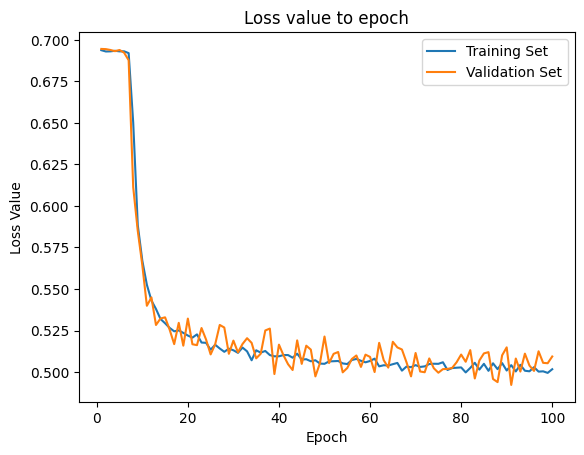

In [47]:
total_epoch = np.linspace(1, epochs, epochs)
plt.title('Loss value to epoch')
plt.plot(total_epoch, cost_value, label = 'Training Set')
plt.plot(total_epoch, cost_valid_value, label = 'Validation Set')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.savefig(f'{OUT_BASE}/Loss.png', bbox_inches = 'tight')
plt.show()
plt.close()

In [48]:
device = 'cpu'
classifier = model.to(device)
torch.save(classifier, f'{OUT_BASE}/model.pt')

# Test

100%|██████████| 157/157 [00:10<00:00, 14.70it/s]


TPR: 0.799
FAR: 0.201


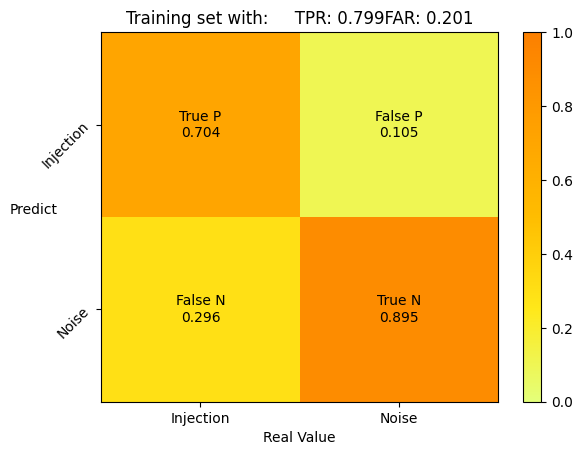

0.799


In [49]:
device = 'cpu'
metrix = torch.zeros([2,2]).to(device)
num_count = torch.zeros([2]).to(device)
dtype = torch.FloatTensor

with torch.no_grad():
    for num, (x, y) in enumerate(tqdm(training_data)):

        Real_label = y.to(device)

        # Convert sofmax output to onehot
        max_class = torch.Tensor.argmax(model(x.to(device)), axis=1)
        pred = F.one_hot(max_class)

        # Accumlating statical value
        metrix += torch.matmul(pred.T.type(dtype), Real_label.type(dtype))
        num_count += Real_label.sum(axis=0)

    num_count = num_count.detach().cpu().numpy().astype('float64')
    metrix = metrix.detach().cpu().numpy().astype('float64')


# Normalizing confusion matrix
metrix /= num_count

# Plotting Scheme
TPR = round((metrix[0,0] + metrix[1,1])/2, 3)
FAR = round(1 - TPR, 3)

print(f'TPR: {TPR}')
print(f'FAR: {FAR}')

lab = np.array([['True P', 'False P'], ['False N', 'True N']])
plt.figure()
color = plt.pcolormesh([metrix[1], metrix[0]], cmap = 'Wistia', vmin=0, vmax=1)
for i in range(2):
    for j in range(2):

        plt.text(i+.5, j+.5,
                 f'{lab[1-j,i]}\n{round(metrix[1-j,i],3)}',
                 ha = 'center',
                 va = 'center')

plt.xticks([.5, 1.5], ['Injection', 'Noise'])
plt.yticks([.5, 1.5], ['Noise', 'Injection'], rotation=45)
plt.xlabel('Real Value')
plt.ylabel('Predict', rotation=0)
plt.title(
    f'Training set with:     TPR: {TPR}FAR: {FAR}'
)
plt.colorbar(color)
plt.savefig(f'{OUT_BASE}/Training_set_performance.png', bbox_inches = 'tight')
plt.show()
plt.close()
print(TPR)

100%|██████████| 32/32 [00:00<00:00, 32.15it/s]


TPR: 0.774
FAR: 0.226


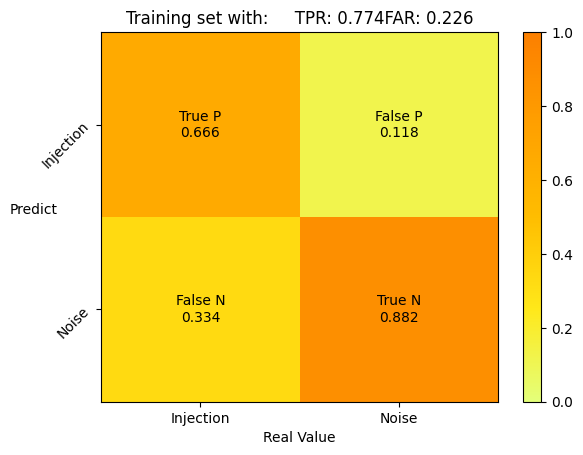

In [50]:
metrix = torch.zeros([2,2]).to(device)
num_count = torch.zeros([2]).to(device)
dtype = torch.FloatTensor

with torch.no_grad():
    for num, (x, y) in enumerate(tqdm(validation_data)):

        Real_label = y.to(device)

        # Convert sofmax output to onehot
        max_class = torch.Tensor.argmax(model(x.to(device)), axis=1)
        pred = F.one_hot(max_class)

        # Accumlating statical value
        metrix += torch.matmul(pred.T.type(dtype), Real_label.type(dtype))
        num_count += Real_label.sum(axis=0)

    num_count = num_count.detach().cpu().numpy().astype('float64')
    metrix = metrix.detach().cpu().numpy().astype('float64')


# Normalizing confusion matrix
metrix /= num_count

# Plotting Scheme
TPR = round((metrix[0,0] + metrix[1,1])/2, 3)
FAR = round(1 - TPR, 3)


print(f'TPR: {TPR}')
print(f'FAR: {FAR}')

lab = np.array([['True P', 'False P'], ['False N', 'True N']])
plt.figure()
color = plt.pcolormesh([metrix[1], metrix[0]], cmap = 'Wistia', vmin=0, vmax=1)
for i in range(2):
    for j in range(2):

        plt.text(i+.5, j+.5,
                 f'{lab[1-j,i]}\n{round(metrix[1-j,i],3)}',
                 ha = 'center',
                 va = 'center')

plt.xticks([.5, 1.5], ['Injection', 'Noise'])
plt.yticks([.5, 1.5], ['Noise', 'Injection'], rotation=45)
plt.xlabel('Real Value')
plt.ylabel('Predict', rotation=0)
plt.title(
    f'Training set with:     TPR: {TPR}FAR: {FAR}'
)
plt.colorbar(color)
plt.savefig(f'{OUT_BASE}/Validation_set_performance.png', bbox_inches = 'tight')
plt.show()
plt.close()

In [20]:
Kate_Moss = MyModel(num_ifos = IFOS)
Kate_Moss = torch.load(f'{OUT_BASE}/model.pt')
Kate_Moss.eval()
Kate_Moss.to(device)

MyModel(
  (conv1): Conv1d(1, 10, kernel_size=(5,), stride=(2,), padding=(2,))
  (norm1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(10, 20, kernel_size=(5,), stride=(2,), padding=(2,))
  (norm3): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(20, 10, kernel_size=(5,), stride=(2,), padding=(2,))
  (norm4): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(10, 5, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv1_drop): Dropout1d(p=0.5, inplace=False)
  (fc1): Linear(in_features=160, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)

In [21]:
dataset_t = MyDataset(strains[1], targets[1])
test_data = DataLoader(
    dataset_t,
    batch_size=32,
    shuffle=True
)

100%|██████████| 32/32 [00:00<00:00, 32.42it/s]


TPR: 0.775
FAR: 0.225


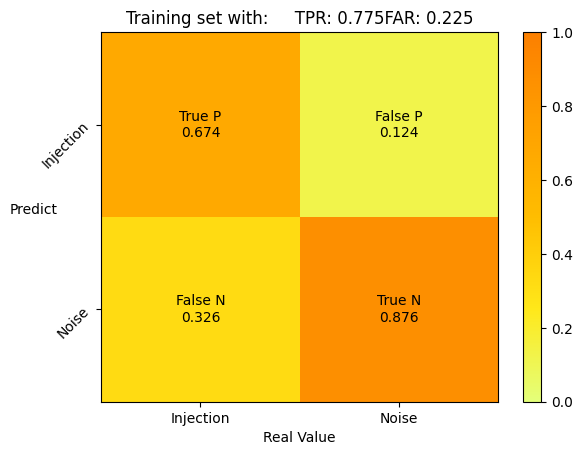

In [51]:
device = 'cpu'

metrix = torch.zeros([2,2]).to(device)
num_count = torch.zeros([2]).to(device)
dtype = torch.FloatTensor

with torch.no_grad():
    for num, (x, y) in enumerate(tqdm(test_data)):

        Real_label = y.to(device)

        # Convert sofmax output to onehot
        max_class = torch.Tensor.argmax(model(x.to(device)), axis=1)
        pred = F.one_hot(max_class)

        # Accumlating statical value
        metrix += torch.matmul(pred.T.type(dtype), Real_label.type(dtype))
        num_count += Real_label.sum(axis=0)

    num_count = num_count.detach().cpu().numpy().astype('float64')
    metrix = metrix.detach().cpu().numpy().astype('float64')


# Normalizing confusion matrix
metrix /= num_count

# Plotting Scheme
TPR = round((metrix[0,0] + metrix[1,1])/2, 3)
FAR = round(1 - TPR, 3)

print(f'TPR: {TPR}')
print(f'FAR: {FAR}')

lab = np.array([['True P', 'False P'], ['False N', 'True N']])
plt.figure()
color = plt.pcolormesh([metrix[1], metrix[0]], cmap = 'Wistia', vmin=0, vmax=1)
for i in range(2):
    for j in range(2):

        plt.text(i+.5, j+.5,
                 f'{lab[1-j,i]}\n{round(metrix[1-j,i],3)}',
                 ha = 'center',
                 va = 'center')

plt.xticks([.5, 1.5], ['Injection', 'Noise'])
plt.yticks([.5, 1.5], ['Noise', 'Injection'], rotation=45)
plt.xlabel('Real Value')
plt.ylabel('Predict', rotation=0)
plt.title(
    f'Training set with:     TPR: {TPR}FAR: {FAR}'
)
plt.colorbar(color)
plt.savefig(f'{OUT_BASE}/Test_set_performance.png', bbox_inches = 'tight')
plt.show()
plt.close()